In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import os

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
# 1. Load the KITTI dataset (tùy chỉnh)
class KITTIDataset(Dataset):
    def __init__(self, image_paths, depth_paths, transform=None):
        self.image_paths = image_paths
        self.depth_paths = depth_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        try:
            image = Image.open(self.image_paths[idx]).convert("RGB")
            depth = Image.open(self.depth_paths[idx]).convert("L")

            if self.transform:
                image = self.transform(image)
                depth = self.transform(depth)

            depth = depth.float() / 65535.0
            return image, depth

        except Exception as e:
            print(f"Error loading data at index {idx}: {e}")
            # Có thể trả về một giá trị mặc định hoặc raise lại exception
            return None, None  # Hoặc raise e

In [10]:
base_path = "data/kitti/kitti/"

with open(base_path + "filenames.txt", "r", encoding="utf-8-sig") as f:
    image_paths = [base_path + line.strip() for line in f.readlines()]

with open(base_path + "gt_filenames.txt", "r", encoding="utf-8-sig") as f:
    depth_paths = [base_path + line.strip() for line in f.readlines()]

print(f"Number of images: {len(image_paths)}")
print(f"Number of depth maps: {len(depth_paths)}")

for i in range(5):
    print(f"Image: {image_paths[i]}")
    print(f"Depth: {depth_paths[i]}")
    print()


Number of images: 742
Number of depth maps: 742
Image: data/kitti/kitti/2011_09_26_drive_0001_sync/2011_09_26/2011_09_26_drive_0001_sync/image_02/data/0000000005.png
Depth: data/kitti/kitti/data_depth_annotated/2011_09_26_drive_0001_sync/proj_depth/groundtruth/image_02/0000000005.png

Image: data/kitti/kitti/2011_09_26_drive_0001_sync/2011_09_26/2011_09_26_drive_0001_sync/image_02/data/0000000006.png
Depth: data/kitti/kitti/data_depth_annotated/2011_09_26_drive_0001_sync/proj_depth/groundtruth/image_02/0000000006.png

Image: data/kitti/kitti/2011_09_26_drive_0001_sync/2011_09_26/2011_09_26_drive_0001_sync/image_02/data/0000000007.png
Depth: data/kitti/kitti/data_depth_annotated/2011_09_26_drive_0001_sync/proj_depth/groundtruth/image_02/0000000007.png

Image: data/kitti/kitti/2011_09_26_drive_0001_sync/2011_09_26/2011_09_26_drive_0001_sync/image_02/data/0000000008.png
Depth: data/kitti/kitti/data_depth_annotated/2011_09_26_drive_0001_sync/proj_depth/groundtruth/image_02/0000000008.png



In [11]:
# 2. Preprocessing (Transforms)
# Use torchvision transforms for consistency and GPU acceleration
transform = transforms.Compose([
    transforms.Resize((256, 1024), interpolation=transforms.InterpolationMode.BILINEAR),
    transforms.ToTensor(),  # Converts to tensor and scales to [0, 1] (for RGB)
    # Depth is normalized in the Dataset class __getitem__
])

# Nearest neighbor for depth (important to preserve distinct values)
transform_depth = transforms.Compose([
    transforms.Resize((256, 1024), interpolation=transforms.InterpolationMode.NEAREST),
    transforms.ToTensor()
])

dataset = KITTIDataset(image_paths, depth_paths, transform=transform)


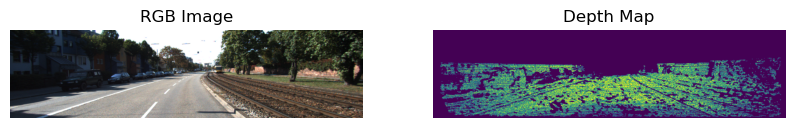

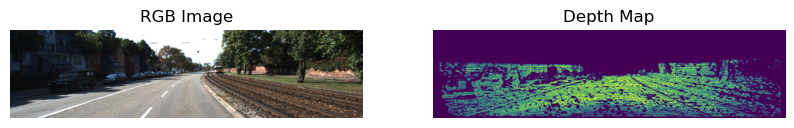

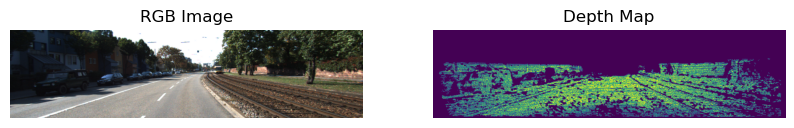

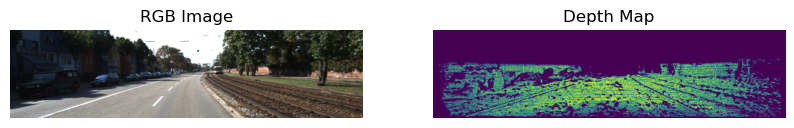

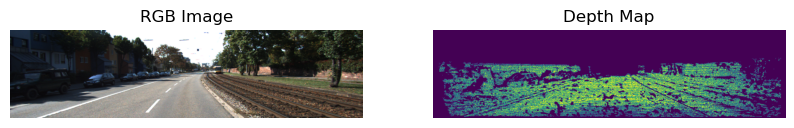

In [16]:
# Sample visualization (optional, but good for debugging)
for i in range(5):
    image, depth = dataset[i]
    image = image.numpy().transpose((1, 2, 0))  # C, H, W -> H, W, C for matplotlib
    depth = depth.numpy().squeeze()

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title("RGB Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(depth)
    plt.title("Depth Map")
    plt.axis("off")
    plt.show()

In [17]:
# 3. Model Definition (U-Net in PyTorch)

class DoubleConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),  # Batch Norm is generally better than Dropout inside blocks
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
        super().__init__()
        self.downs = nn.ModuleList()
        self.ups = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNet
        for feature in features:
            self.downs.append(DoubleConvBlock(in_channels, feature))
            in_channels = feature

        # Up part of UNet
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature * 2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConvBlock(feature * 2, feature))

        self.bottleneck = DoubleConvBlock(features[-1], features[-1] * 2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)
        self.dropout = nn.Dropout(0.5)  #Dropout after pooling and before upsampling

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)
            x = self.dropout(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]  # Reverse the list

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx // 2]
            # Input resizing (if necessary, due to integer division)
            if x.shape != skip_connection.shape:
                x = F.interpolate(x, size=skip_connection.shape[2:], mode='bilinear', align_corners=True)

            concat_skip = torch.cat((skip_connection, x), dim=1)  # Concat along channel dim
            x = self.dropout(concat_skip)
            x = self.ups[idx + 1](x)

        return self.final_conv(x)


In [18]:
# 4. Loss Function (Scale-Invariant Loss in PyTorch)
def scale_invariant_loss(y_true, y_pred):
    diff = y_true - y_pred
    return torch.mean(diff ** 2) - 0.5 * (torch.mean(diff) ** 2)

In [19]:
# 5. Training Loop
def train_model(model, train_loader, val_loader, optimizer, loss_fn, epochs=5, steps_per_epoch=None,
                validation_steps=None):
    history = {'loss': [], 'val_loss': [], 'mae': [], 'val_mae': []}  # Store history
    model.to(device)  # Move model to GPU if available

    for epoch in range(epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0
        running_mae = 0.0

        for i, (images, depths) in enumerate(train_loader):
            images = images.to(device)
            depths = depths.to(device)

            optimizer.zero_grad()  # Zero the parameter gradients

            outputs = model(images)
            loss = loss_fn(depths, outputs)

            with torch.no_grad():  # Calculate MAE *without* tracking gradients
                mae = torch.mean(torch.abs(depths - outputs))

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            running_mae += mae.item()

            if steps_per_epoch is not None and i >= steps_per_epoch - 1:
                break

        epoch_loss = running_loss / (i + 1)
        epoch_mae = running_mae / (i + 1)
        history['loss'].append(epoch_loss)
        history['mae'].append(epoch_mae)

        print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss:.4f}, MAE: {epoch_mae:.4f} ", end="")

        # Validation
        model.eval()  # Set the model to evaluation mode
        val_running_loss = 0.0
        val_running_mae = 0.0
        with torch.no_grad():  # No gradients needed for validation
            for j, (val_images, val_depths) in enumerate(val_loader):
                val_images = val_images.to(device)
                val_depths = val_depths.to(device)

                val_outputs = model(val_images)
                val_loss = loss_fn(val_depths, val_outputs)
                val_mae = torch.mean(torch.abs(val_depths - val_outputs))

                val_running_loss += val_loss.item()
                val_running_mae += val_mae.item()

                if validation_steps is not None and j >= validation_steps - 1:
                    break

        val_epoch_loss = val_running_loss / (j + 1)
        val_epoch_mae = val_running_mae / (j + 1)
        history['val_loss'].append(val_epoch_loss)
        history['val_mae'].append(val_epoch_mae)

        print(f"Val Loss: {val_epoch_loss:.4f}, Val MAE: {val_epoch_mae:.4f}")

    return history

In [20]:
# 6. Data Loaders and Training Setup
split_index = int(0.8 * len(image_paths))
train_dataset = KITTIDataset(image_paths[:split_index], depth_paths[:split_index], transform=transform)
val_dataset = KITTIDataset(image_paths[split_index:], depth_paths[split_index:], transform=transform)

batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4,
                          pin_memory=True)  # num_workers > 0 for faster loading
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4,
                        pin_memory=True)  # No need to shuffle validation data
steps_per_epoch = int(len(train_dataset) * 0.8 // batch_size)  #80 percent of the data
validation_steps = int(len(val_dataset) * 0.2 // batch_size)  #20 percent for validation

In [ ]:
# 7. Model, Optimizer, Loss, and Training
unet_model = UNet(in_channels=3, out_channels=1).to(device)
optimizer = optim.Adam(unet_model.parameters())  # Use Adam optimizer
loss_function = scale_invariant_loss

model_history = train_model(unet_model, train_loader, val_loader, optimizer, loss_function, epochs=5,
                            steps_per_epoch=steps_per_epoch, validation_steps=validation_steps)



In [11]:
# 8. Plot Training History (same as before)

def plot_training_history(history):
    epochs = range(1, len(history['loss']) + 1)

    # Plot loss
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['loss'], 'bo-', label='Training Loss')
    plt.plot(epochs, history['val_loss'], 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    if 'mae' in history and 'val_mae' in history:
        plt.subplot(1, 2, 2)
        plt.plot(epochs, history['mae'], 'bo-', label='Training MAE')
        plt.plot(epochs, history['val_mae'], 'ro-', label='Validation MAE')
        plt.title('Training and Validation MAE')
        plt.xlabel('Epochs')
        plt.ylabel('MAE')
        plt.legend()

    plt.show()


plot_training_history(model_history)

In [ ]:
# 9. Prediction and Visualization (adapted for PyTorch)
def predict_and_display(model, val_loader, num_examples=3):
    model.eval()  # Set model to evaluation mode
    val_batch = next(iter(val_loader))
    val_rgb, val_depth = val_batch
    val_rgb = val_rgb.to(device)
    val_depth = val_depth.to(device)

    with torch.no_grad():  # Disable gradient calculations
        pred_depth = model(val_rgb)

    plt.figure(figsize=(25, 15))
    for i in range(num_examples):
        # Input RGB
        plt.subplot(3, num_examples, i + 1)
        plt.imshow(val_rgb[i].cpu().numpy().transpose((1, 2, 0)))  #CHW to HWC
        plt.title("Input RGB")
        plt.axis("off")

        # Ground Truth Depth (moved to CPU for numpy)
        gt_depth = val_depth[i].cpu().numpy().squeeze()
        plt.subplot(3, num_examples, num_examples + i + 1)
        plt.imshow(gt_depth, cmap="gray")
        plt.title(f"Ground Truth (min: {gt_depth.min():.2f}, max: {gt_depth.max():.2f})")
        plt.axis("off")

        # Predicted Depth (moved to CPU for numpy)
        pred = pred_depth[i].cpu().numpy().squeeze()
        plt.subplot(3, num_examples, 2 * num_examples + i + 1)
        plt.imshow(pred, cmap="gray")
        plt.title(f"Prediction (min: {pred.min():.2f}, max: {pred.max():.2f})")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


In [ ]:
predict_and_display(unet_model, val_loader, num_examples=3)
